# Overview
The **objective** of this notebook is to visualize the data assimilation results generated from [the DART_PFLOTRAN_Integrate notebook](./DART_PFLOTRAN_Integrate.ipynb):
1. [x] [Configuration](#parameter): define directories, file locations, and other parameters
- [x] [Visualize spatial average](#plot_spatial_average): plot the time evolution of spatial-averaged prior and posterior results
- [x] [Visualize time evolution along one axis](#plot_along_zaxis):

<a id='parameter'></a>
# Configuration

In [68]:
import os
import sys
import h5py
import pickle
import f90nml
import subprocess
import numpy as np
from math import floor
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import gridspec
# plt.rcParams['figure.constrained_layout.use'] = True
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


****************
**Define the locations of application folder, DART-PFLOTRAN interface folder, and the configuation file of interest**

In [2]:
# Main directory names
temp_app_dir = "/Users/jian449/Codes/DART/manhattan/models/pflotran/applications/template"          # The template for application folder
app_par_dir  = "/Users/jian449/Codes/DART/manhattan/models/pflotran/applications"
app_dir_name = "1dthermal_test_1month_1mda"
app_dir      = os.path.join(app_par_dir, app_dir_name)          # The application folder name
dart_dir     = "/Users/jian449/Codes/DART/manhattan"
dart_pf_dir  = "/Users/jian449/Codes/DART/manhattan/models/pflotran"     # The dart pflotran utitlity folder name
fig_dir      = "/Users/jian449/OneDrive - PNNL/Documents/Publications/2020DART_PFLOTRAN/simulation_plots"
# temp_app_dir = os.path.abspath("../template" )          # The template for application folder
# app_dir      = os.path.abspath("../1dthermal/")          # The application folder name
# dart_dir     = os.path.abspath("../../../../")
# dart_pf_dir  = os.path.join(dart_dir, "models/pflotran")     # The dart pflotran utitlity folder name
# Get the configuration file
config_file  = os.path.join(app_dir, "work/config.nml")

****************
**Change the locations of the all the files saved in the original config_file according to the new defined locations if necessary (this is used for the case that the application folder is moved/copied from another location)**

In [3]:
change_path_name_files = os.path.join(dart_pf_dir, "utils/change_file_paths_in_confignml.py")
subprocess.run("python {} {} {} {}".format(change_path_name_files, config_file, dart_pf_dir, app_dir),
               shell=True, check=True)


CompletedProcess(args='python /Users/jian449/Codes/DART/manhattan/models/pflotran/utils/change_file_paths_in_confignml.py /Users/jian449/Codes/DART/manhattan/models/pflotran/applications/1dthermal_test_1month_1mda/work/config.nml /Users/jian449/Codes/DART/manhattan/models/pflotran /Users/jian449/Codes/DART/manhattan/models/pflotran/applications/1dthermal_test_1month_1mda', returncode=0)

****************
**Import the visualization functions**

In [4]:
sys.path.append(dart_pf_dir)
from utils.plot_da_result import DaResults, plot_compare_multiple_daresults
dar = DaResults(config_file)
dar.setup(from_concatenated=0)
nvar = dar.nvar

# Results from the improved DART

<a id='plot_spatial_average'></a>
## Visualize spatial average results

/usr/local/anaconda3/envs/geosci/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  func(*args, **kwargs)
/usr/local/anaconda3/envs/geosci/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


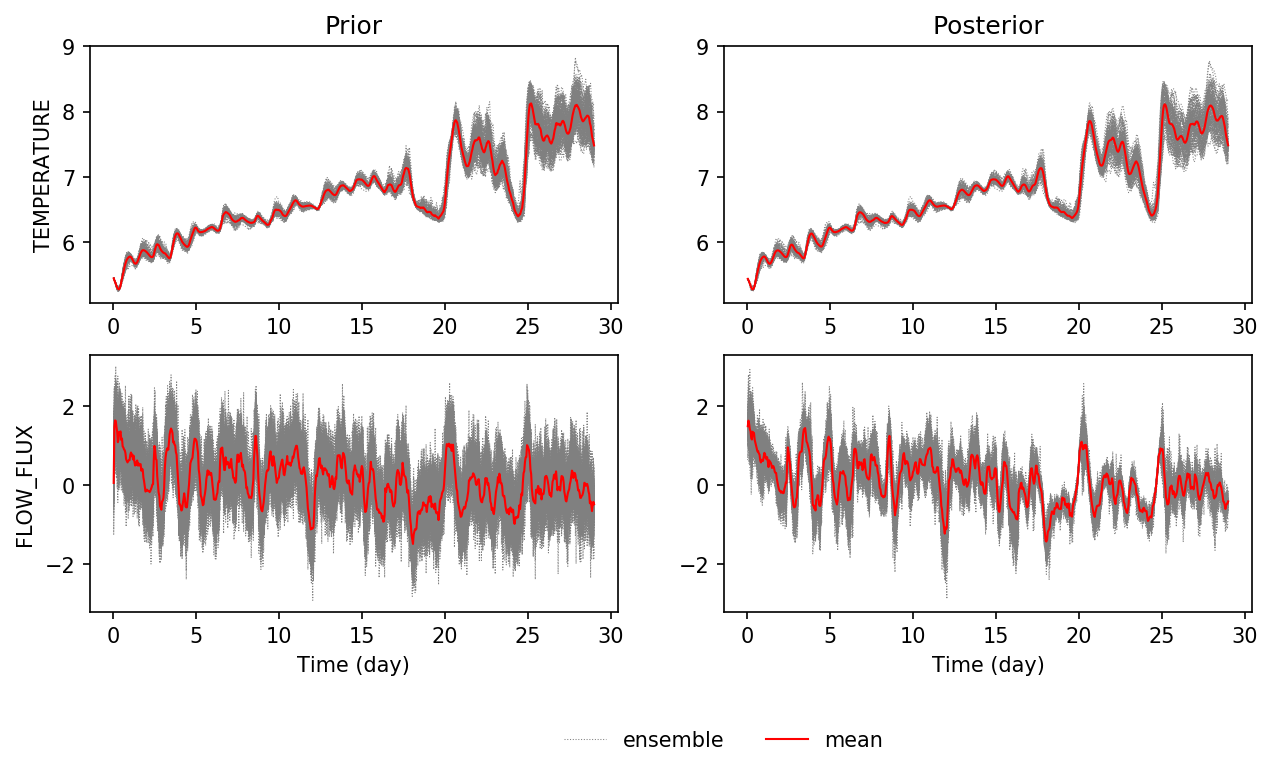

In [5]:
fig = plt.figure(num=1,dpi=150, figsize=(10,5), constrained_layout=True)
gs = gridspec.GridSpec(nvar, 2, width_ratios=[1, 1])
axes = np.empty([nvar, 2], dtype=object)
for i in range(nvar):
    axes[i, 0] = plt.subplot(gs[i, 0])
    axes[i, 1] = plt.subplot(gs[i, 1], sharey=axes[i, 0], sharex=axes[i, 0])
dar.plot_spatial_average(axes)

<a id='plot_along_zaxis'></a>
## Temperature (from netCDF file)

In [6]:
os.path.join(fig_dir, app_dir_name+"_temperature.png")

'/Users/jian449/OneDrive - PNNL/Documents/Publications/2020DART_PFLOTRAN/simulation_plots/1dthermal_test_1month_1mda_temperature.png'

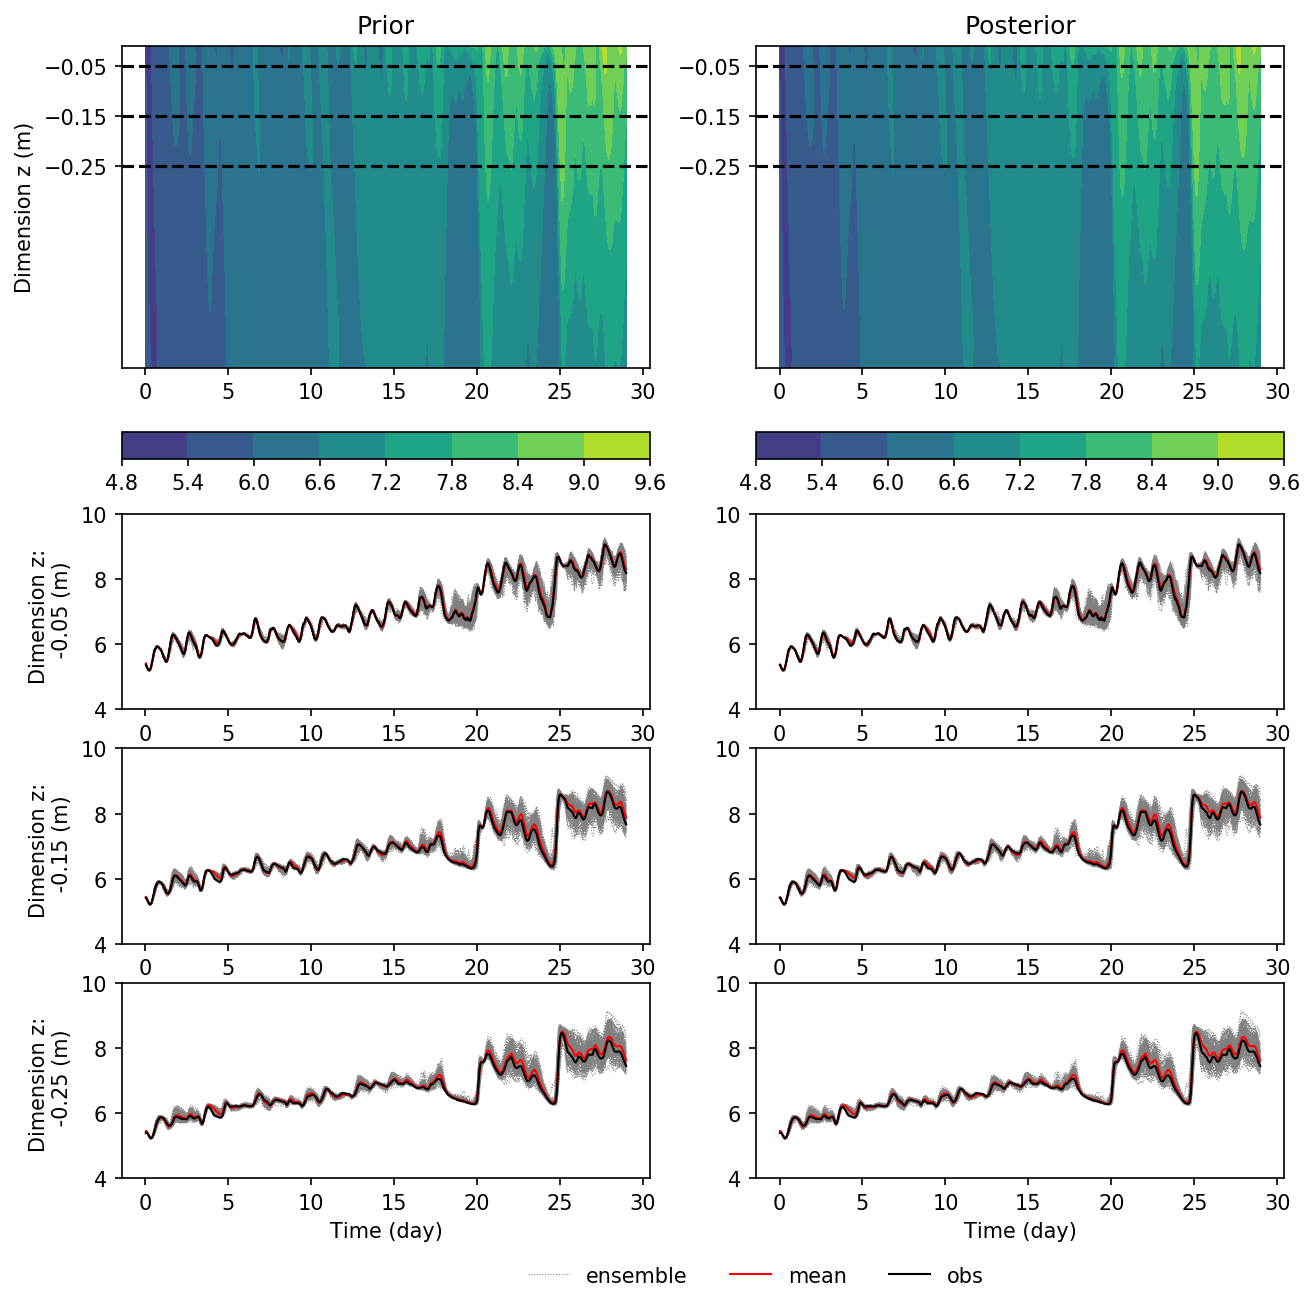

In [48]:
dar.plot_oned_obs('TEMPERATURE', figsize=(10,10), dim_str='z', vmin=4, vmax=10, ylim=[4, 10])
# plt.savefig(os.path.join(fig_dir, app_dir_name+"_temperature.png"), dpi=150)

## Temperature (from HDF5 file)
Note that the HDF5 file contains model states in different time steps

In [196]:
# Get the posterior from the model output
pflotran_out = os.path.join(app_dir, "pflotran_output")
posterior_temp_from_h = os.path.join(pflotran_out,'posterior_temperature_fromh5.npy')
if os.path.exists(posterior_temp_from_h):
    posterior = np.load(posterior_temp_from_h)
else:
    for i in range(nens):
        file_name = os.path.join(pflotran_out, "pflotranR{}.h5".format(i+1))

        var_name = 'Temperature [C]'

        f_out = h5py.File(file_name, 'r')

        # Get all the time steps
        time_set_o = np.array([t for t in list(f_out.keys()) if t.startswith("Time")])
        time_set   = np.array([t.split()[1:] for t in time_set_o])
        time_vset  = np.array([float(t[0]) for t in time_set])
        time_unit  = time_set[0][1]

        # Shift the time_vset by the model spinup time
        # time_vset = time_vset - spinup_time * 86400

        if time_unit in ["s", "sec", "second"]: # Convert from seconds to fractional days
            time_vset_day  = time_vset / 86400. 
            
        # Sort the time indices
        indices = np.argsort(time_vset)
        time_vset_sorted = time_vset[indices]
        time_vset_day_sorted = time_vset_day[indices]
        time_set_o_sorted = time_set_o[indices]

        if i == 0:
            posterior = np.zeros([65, len(time_set), nens])

        # Get the state/parameter/variable values required in pflotran_var_set
        for j in range(len(time_vset)):
            time_o           = time_set_o_sorted[j]
            dataset          = f_out[time_o]
            pl_out_var_set_o = list(dataset.keys())
            posterior[:,j,i] = dataset[var_name][:]
    np.save(posterior_temp_from_h, posterior)

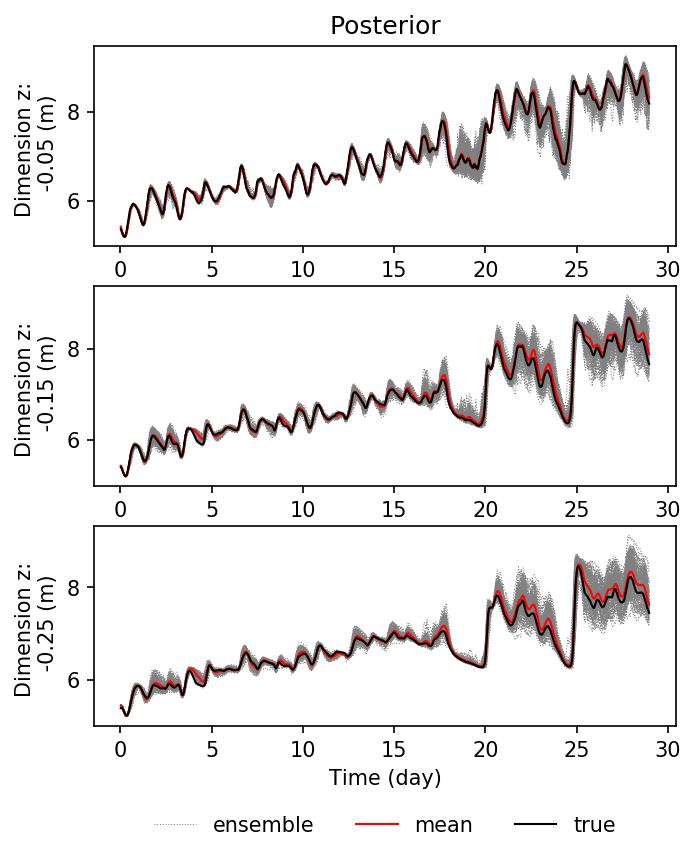

In [197]:
# Get the parameter
obs_set               = dar.obs_set
pflotran_var_set      = dar.pflotran_var_set
model_time_list       = dar.model_time_list
model_time_dates_list = dar.model_time_dates_list
obs_time_set_used     = dar.obs_time_set_used
obs_value_set_used    = dar.obs_value_set_used
obs_loc_set           = dar.obs_loc_set

ntime = len(obs_time_set_used)

model_time_list2 = np.arange(model_time_list[0], model_time_list[-1], 300./86400)
spinup_dt_num = int(3600*2/300)
posterior_set = [posterior[-5,1:ntime+1,:],posterior[-15,1:ntime+1,:],posterior[-25,1:ntime+1,:]]

xloc_set, yloc_set, zloc_set = dar.x_loc, dar.y_loc, dar.z_loc

# Get the locations associated with this observation variable
_, nloc = obs_loc_set.shape
# nvar_obs = len(obs_set)

# Plot
fig = plt.figure(num=1, dpi=150, figsize=(5,6), constrained_layout=True)
gs = gridspec.GridSpec(nloc, 1, height_ratios=[1, 1, 1])

# Define axes array
axes = np.empty(nloc, dtype=object)

##############################
# Plot the temporal evolution of the ensemble, the mean, and the observation
# at each observed location
for i in range(nloc):
    posterior_current = posterior_set[i]
    ax1 = plt.subplot(gs[i])
    for j in range(nens):
        posterior_ens = posterior_current[:, j]
        line1, = ax1.plot(obs_time_set_used, posterior_ens, color='grey', linewidth=0.5, linestyle=':', label='ensemble')
    posterior_mean = np.mean(posterior_current, axis=(1))
    
    # Plot the posterior
    line2, = ax1.plot(obs_time_set_used, posterior_mean, color='red', linewidth=1, label='mean')
    obs_used = obs_value_set_used['TEMPERATURE'][i, :]
    line3, = ax1.plot(obs_time_set_used, obs_used, color='black', linewidth=1, label='obs')
    ax.set_ylim([4, 10])

    axes[i] = ax1

# Plot the legends
# plt.legend(frameon=False, ncol=3, loc="upper center", bbox_to_anchor=(0.9, -0.3))
plt.legend((line1, line2, line3), ('ensemble', 'mean', 'true'), frameon=False, ncol=3, loc="center", bbox_to_anchor=(0.5, -0.5))

# Plot the labels and titles
axes[0].set_title("Posterior")
axes[-1].set_xlabel("Time (day)")
for i in range(nloc):
    axes[i].set_ylabel("Dimension z: \n %.2f (m)" % (obs_loc_set[2, i]))

Text(0.5, 0, 'Time (day)')

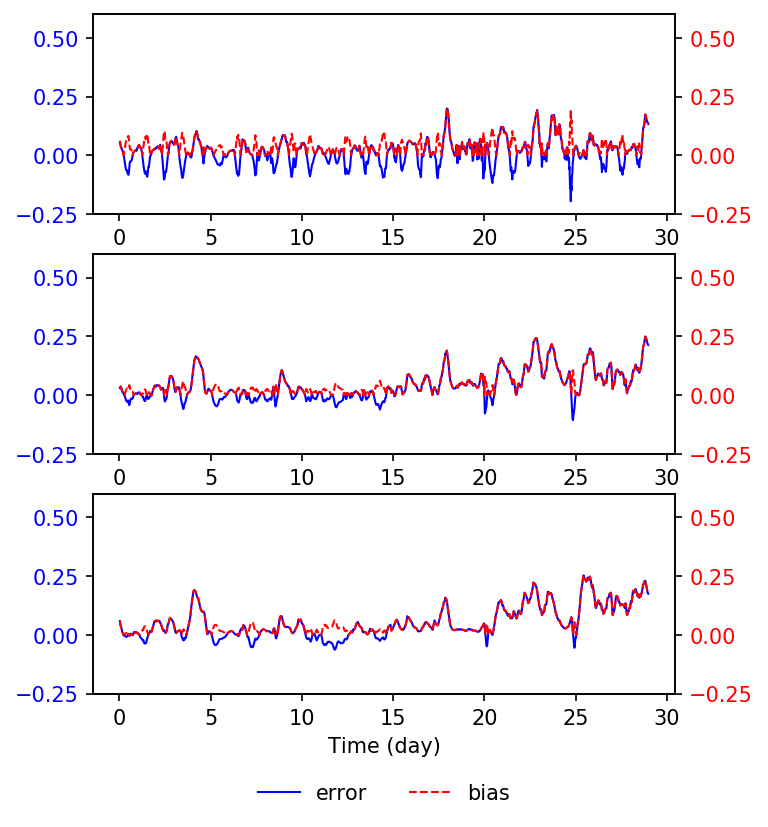

In [198]:
# Get the parameter
obs_set               = dar.obs_set
pflotran_var_set      = dar.pflotran_var_set
model_time_list       = dar.model_time_list
model_time_dates_list = dar.model_time_dates_list
obs_time_set_used     = dar.obs_time_set_used
obs_value_set_used    = dar.obs_value_set_used
obs_loc_set           = dar.obs_loc_set

ntime = len(obs_time_set_used)

# Plot
fig = plt.figure(num=1, dpi=150, figsize=(5,6), constrained_layout=True)
gs = gridspec.GridSpec(nloc, 1, height_ratios=[1, 1, 1])

# Define axes array
axes = np.empty(nloc, dtype=object)

##############################
# Plot the temporal evolution of the ensemble, the mean, and the observation
# at each observed location
for i in range(nloc):
    posterior_current = posterior_set[i]
    obs_used = obs_value_set_used['TEMPERATURE'][i, :]
    
    # Plot the error
    ax2 = plt.subplot(gs[i])
    diff = np.zeros([ntime, nens])
    for j in range(nens):
        diff[:, j] = posterior_current[:,j] - obs_used
    diff_mean = np.mean(diff, axis=1)
    diff_mean_abs = np.abs(diff_mean)
    diff_std  = np.std(diff, axis=1)
    line1,=ax2.plot(obs_time_set_used, diff_mean, color='blue', linewidth=1, label='mean')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.set_ylim([-.25,.6])
    
    # Plot the bias
    ax22 = ax2.twinx()  # instantiate a second axes that shares the same x-axis
#     ax22.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
    ax22.tick_params(axis='y', labelcolor='red')
    ax22.set_ylim([-.25,.6])
    line2,=ax22.plot(obs_time_set_used, diff_mean_abs, '--', color='red', linewidth=1, label='mean')
#     line3,=ax2.plot(obs_time_set_used, diff_std, '*-', color='black', linewidth=1, label='mean')

    axes[i] = ax2

# Plot the legends
# plt.legend(frameon=False, ncol=3, loc="upper center", bbox_to_anchor=(0.9, -0.3))
plt.legend((line1, line2), ('error', 'bias'), frameon=False, ncol=3, loc="center", bbox_to_anchor=(0.5, -0.5))

# Plot the labels and titles
# axes[0].set_title("Posterior")
axes[-1].set_xlabel("Time (day)")
# for i in range(nloc):
#     axes[i].set_ylabel("Dimension z: \n %.2f (m)" % (obs_loc_set[2, i]))

## Flow flux

In [49]:
os.path.join(fig_dir, app_dir_name+"_flowflux.png")

'/Users/jian449/OneDrive - PNNL/Documents/Publications/2020DART_PFLOTRAN/simulation_plots/1dthermal_test_1month_1mda_flowflux.png'

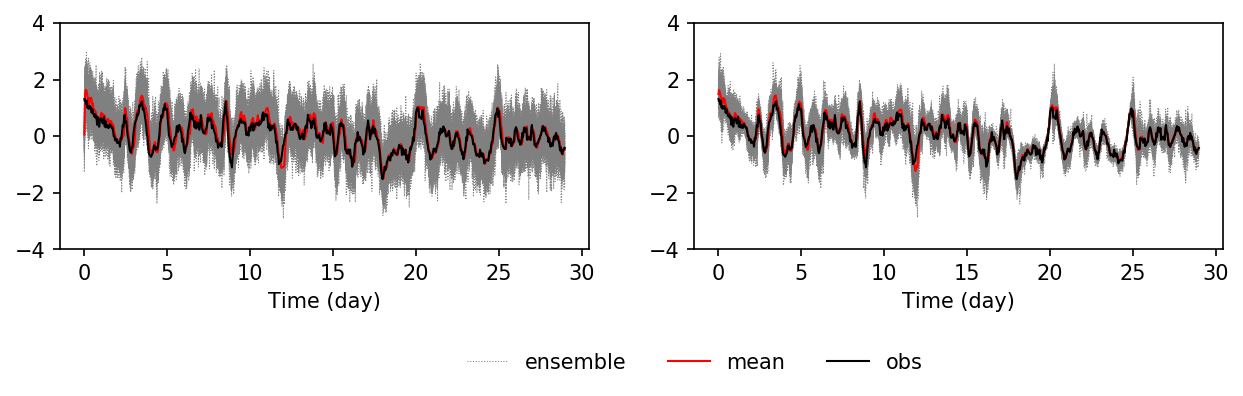

In [50]:
flux_file = os.path.join(app_dir, "pflotran_input/flux_1d_new.csv")
fig = plt.figure(num=1,dpi=150, figsize=(10,2), constrained_layout=False)
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], figure=fig)
axes = np.empty(2, dtype=object)
axes[0] = plt.subplot(gs[0, 0])
axes[1] = plt.subplot(gs[0, 1], sharey=axes[0], sharex=axes[0])
# fig, axes = plt.subplots(1, 2, figsize=(8,3), dpi=150, constrained_layout=True)
dar.compare_univar_spatial_average(var_name='FLOW_FLUX', true_file_name=flux_file, axes=axes, ylim=[-4, 4])
# axes[1].set_xlim([8,9.5])
plt.subplots_adjust(wspace=0.2)
# plt.savefig(os.path.join(fig_dir, app_dir_name+"_flowflux.png"), dpi=150, bbox_inches='tight')

# Results from the original DART

## Temperature (from HDF5 file)
Note that the HDF5 file contains model states in different time steps

## Flow flux

In [52]:
# model_time_list = dar.model_time_list
# print(np.argmin(diff_mean))
# print(true[(true_time_set > model_time_list[np.argmin(diff_mean)]) & (true_time_set <= model_time_list[np.argmin(diff_mean)+1])])
# print(true[(true_time_set > model_time_list[np.argmin(diff_mean)-1]) & (true_time_set <= model_time_list[np.argmin(diff_mean)])])
# print(posterior_mean[np.argmin(diff_mean)], true_mean[np.argmin(diff_mean)])
# # print(model_time_list[np.argmin(diff_mean)-2:np.argmin(diff_mean)+2])
# # print(posterior_mean[np.argmin(diff_mean)-5:np.argmin(diff_mean)+5])
# # print(true_mean[np.argmin(diff_mean)-8:np.argmin(diff_mean)+2])

# Results generated from the original sequential ensemble smoother
We would like to compare EnKF results with Kewei's result

## Flow flux

In [53]:
# Get the Kewei's results
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from datetime import datetime

assim_start_me, assim_start_enks = dar.assim_start_time, "2017-04-01 02:00:00"
flux_posterior_file = os.path.join(app_dir, "pflotran_input/flux_Kewei_posterior_woflowdir_mda1.txt")
flux_prior_file = os.path.join(app_dir, "pflotran_input/flux_Kewei_prior_woflowdir_mda1.txt")
# flux_posterior_file = os.path.join(app_dir, "pflotran_input/flux_Kewei_posterior_woflowdir.txt")
# flux_prior_file = os.path.join(app_dir, "pflotran_input/flux_Kewei_prior_woflowdir.txt")
true_set = pd.read_csv(flux_file)
prior, posterior = np.loadtxt(flux_prior_file), np.loadtxt(flux_posterior_file)
_, nens = prior.shape
assim_window = 1. / 24.  # Kewei's assimilation window (1hr)
fraction = int(assim_window / dar.assim_window)

In [54]:
# Get the time index
model_start_time, model_end_time = dar.model_start_time, dar.model_end_time
ref_time           = datetime.strptime(assim_start_me, "%Y-%m-%d %H:%M:%S")
true_set_raw_time  = true_set.iloc[:, 0].values
true_set_dates     = np.array([datetime.strptime(t, '%m/%d/%Y %H:%M') for t in true_set_raw_time])
dates_ref          = [t-ref_time for t in true_set_dates]
true_set_time      = np.array([t.days+float(t.seconds)/86400. for t in dates_ref])
true               = true_set.iloc[:, 1].values
true_set_used_ind  = (true_set_time >= model_start_time) & (true_set_time <= model_end_time)
true_set_time_used = true_set_time[true_set_used_ind]
true_set_used      = true[true_set_used_ind]

# ref_time_enks      = datetime.strptime(assim_start_enks, "%Y-%m-%d %H:%M:%S")
# enks_set_time = true_set_time[true_set_dates > ref_time_enks]
# enks_ind  = (enks_set_time >= model_start_time) & (enks_set_time <= model_end_time)
model_time_list = [dar.model_time_list[i] for i in range(len(dar.model_time_list))  if i % fraction == 0]
ntime = len(model_time_list)
analyzed_prior_ens = prior[:ntime,:].T
analyzed_posterior_ens = posterior[1:1+ntime, :].T

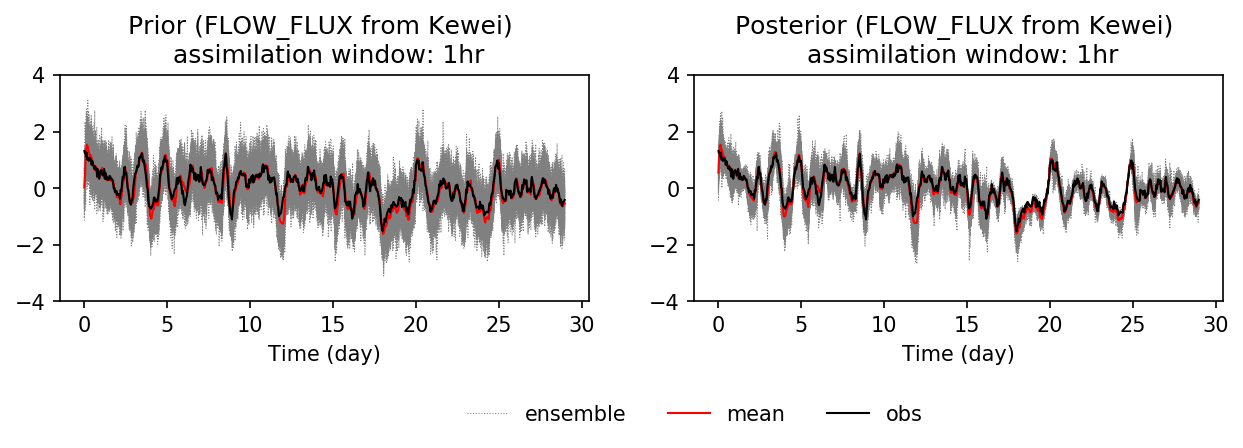

In [55]:
# Plot
ylim=[-4, 4]
fig = plt.figure(num=1, dpi=150,figsize=(10, 2), constrained_layout=True)
gs  = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
# Plot the prior
ax1 = plt.subplot(gs[0, 0])
# shift = 12
# for j in range(nens):
#     prior_ens = analyzed_prior_ens[j, :]
#     line1, = ax1.plot(model_time_list[:-shift], prior_ens[:-shift], color='grey',
#                       linewidth=0.5, linestyle=':', label='ensemble')
# prior_mean = np.mean(analyzed_prior_ens, axis=(0))
# line2, = ax1.plot(model_time_list[:-shift], prior_mean[:-shift], color='red',
#                   linewidth=1, label='mean')
# line3, = ax1.plot(true_set_time_used[:-shift], true_set_used[shift:], color='black',
#                   linewidth=1, label='obs')
for j in range(nens):
    prior_ens = analyzed_prior_ens[j, :]
    line1, = ax1.plot(model_time_list, prior_ens, color='grey',
                      linewidth=0.5, linestyle=':', label='ensemble')
prior_mean = np.mean(analyzed_prior_ens, axis=(0))
line2, = ax1.plot(model_time_list, prior_mean, color='red',
                  linewidth=1, label='mean')
line3, = ax1.plot(true_set_time_used, true_set_used, color='black',
                  linewidth=1, label='obs')

# Plot the posterior
ax2 = plt.subplot(gs[0, 1])
for j in range(nens):
    posterior_ens = analyzed_posterior_ens[j, :]
    line1, = ax2.plot(model_time_list, posterior_ens, color='grey',
                      linewidth=0.5, linestyle=':', label='ensemble')
posterior_mean = np.mean(analyzed_posterior_ens, axis=(0))
line2, = ax2.plot(model_time_list, posterior_mean, color='red',
                  linewidth=1, label='mean')
line3, = ax2.plot(true_set_time_used, true_set_used, color='black',
                  linewidth=1, label='obs')

# Plot the legends
plt.legend((line1, line2, line3), ('ensemble', 'mean', 'obs'),
           frameon=False, ncol=3, loc="center", bbox_to_anchor=(0.0, -0.5))

# Plot the labels and titles
ax1.set_title("Prior ({} from Kewei) \n assimilation window: 1hr".format('FLOW_FLUX'))
ax2.set_title("Posterior ({} from Kewei) \n assimilation window: 1hr".format('FLOW_FLUX'))
ax1.set_xlabel("Time (day)")
ax2.set_xlabel("Time (day)")
ax1.set_ylim(ylim)
ax2.set_ylim(ylim);
# ax2.set_xlim([11, 13])

(-1.8, 1.8)

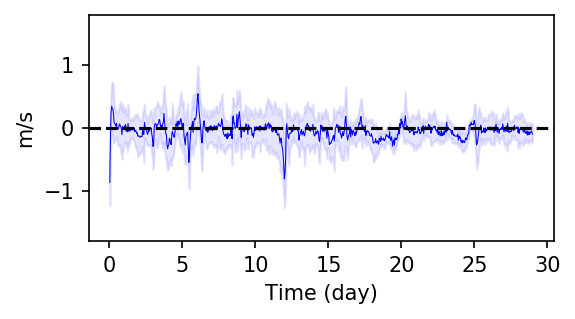

In [56]:
# Plot
_, ax = plt.subplots(1, 1, figsize=(4,2), dpi=150)

# Compute the temporal averaged true values
# true_set_used_ave = [true[true_set_time<=model_time_list[i]][-1] 
#                      for i in range(len(model_time_list))]
model_time_offset = 1800./86400.
true_set_used_ave = [np.mean(true[(true_set_time >  (model_time_list[i-1]+model_time_offset)) & 
                                  (true_set_time <= (model_time_list[i]+model_time_offset))]) 
#                      if i != 0 else np.mean(true[(true_set_time >  (model_time_list[i]-model_time_offset)) & 
#                                                  (true_set_time <= (model_time_list[i]+model_time_offset))])
                     if i != 0 else np.mean(true[true_set_time <= (model_time_list[i]+model_time_offset)])
                     for i in range(len(model_time_list))] 

# Get the difference between the estimated and the true for each realization
diff      = analyzed_posterior_ens - true_set_used_ave
diff_mean = np.mean(diff, axis=0)
diff_std  = np.std(diff, axis=0)

# Plot the posterior
ax.plot(model_time_list[:], diff_mean, color='blue', linewidth=0.5, label='mean of the difference')
ax.fill_between(model_time_list[:], diff_mean-diff_std, diff_mean+diff_std, color='blue', alpha=0.1)
ax.axhline(y=0, color='black', linestyle='--')

# Plot the labels and titles
ax.set_xlabel("Time (day)")
# ax.set_ylabel("ensemble mean - the true")
ax.set_ylabel("m/s")
ax.set_ylim([-1.8, 1.8])
# # Plot the posterior
# line, = ax.plot(model_time_list, diff_mean, color='red',
#                   linewidth=1, label='mean of the difference')
# ax.axhline(y=0, color='red', linestyle='--')
# ax2 = ax.twinx()
# line2, = ax2.plot(model_time_list, diff_std, color='blue',
#                   linewidth=1, label='std of the difference')
# ax2.axhline(y=0.2, color='blue', linestyle='--')

# # Plot the labels and titles
# ax.set_xlabel("Time (day)")
# ax.set_ylabel("mean of the difference ({})".format('m/s'), color='red')
# ax.tick_params(axis='y', labelcolor='red')
# ax2.set_ylabel("std of the difference ({})".format('m/s'), color='blue')
# ax2.tick_params(axis='y', labelcolor='blue')
# ax.set_ylim([-1.5,0.75])
# ax2.set_ylim([0., 1])

In [57]:
# assim_start_me, assim_start_enks = dar.assim_start_time, "2017-04-01 02:00:00"
# temp_posterior_file = os.path.join(app_dir, "pflotran_input/temp_Kewei_posterior_woflowdir_mda1.txt")
# # flux_posterior_file = os.path.join(app_dir, "pflotran_input/flux_Kewei_posterior_woflowdir.txt")
# # flux_prior_file = os.path.join(app_dir, "pflotran_input/flux_Kewei_prior_woflowdir.txt")

# posterior = np.loadtxt(temp_posterior_file)
# posterior.shape

(25812, 100)

## Temperature

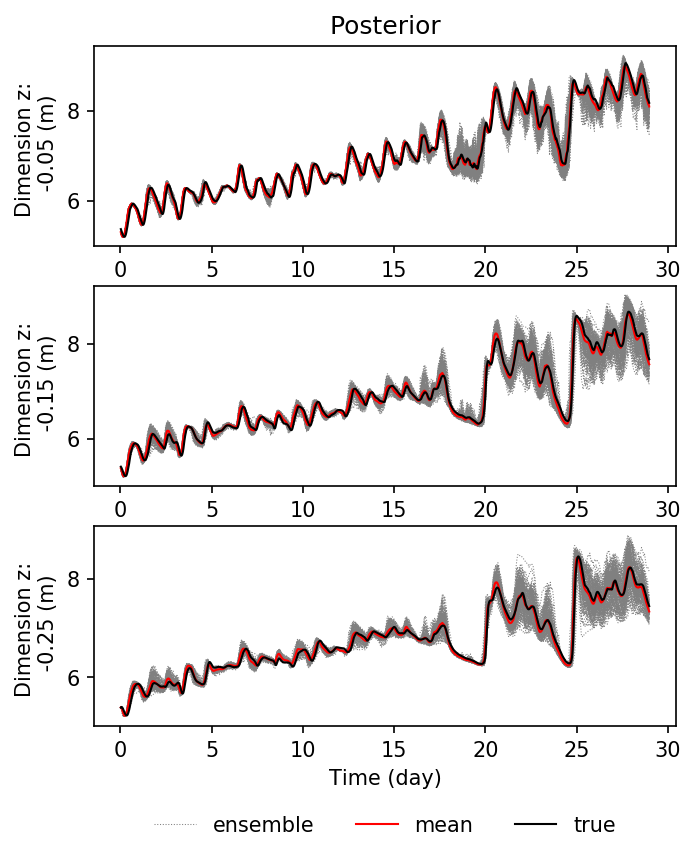

In [192]:
# Get the parameter
assim_start_me, assim_start_enks = dar.assim_start_time, "2017-04-01 02:00:00"
temp_posterior_file = os.path.join(app_dir, "pflotran_input/temp_Kewei_posterior_woflowdir_mda1.txt")
# temp_posterior_file = os.path.join(app_dir, "pflotran_input/temp_Kewei_posterior_woflowdir_mda1.txt")
# flux_posterior_file = os.path.join(app_dir, "pflotran_input/flux_Kewei_posterior_woflowdir.txt")
# flux_prior_file = os.path.join(app_dir, "pflotran_input/flux_Kewei_prior_woflowdir.txt")

posterior = np.loadtxt(temp_posterior_file)
_, nens = posterior.shape

obs_set               = dar.obs_set
pflotran_var_set      = dar.pflotran_var_set
model_time_list       = dar.model_time_list
model_time_dates_list = dar.model_time_dates_list
obs_time_set_used     = dar.obs_time_set_used
obs_value_set_used    = dar.obs_value_set_used
obs_loc_set           = dar.obs_loc_set

ntime = len(obs_time_set_used)

model_time_list2 = np.arange(model_time_list[0], model_time_list[-1], 300./86400)
spinup_dt_num = int(3600*2/300)
posterior = posterior[3*spinup_dt_num:,:]
posterior = posterior[:(len(model_time_list2))*3,:]
posterior_set = [posterior[::3, :], posterior[1::3, :], posterior[2::3, :]]

xloc_set, yloc_set, zloc_set = dar.x_loc, dar.y_loc, dar.z_loc

# Get the locations associated with this observation variable
_, nloc = obs_loc_set.shape
# nvar_obs = len(obs_set)

# Plot
fig = plt.figure(num=1, dpi=150, figsize=(5,6), constrained_layout=True)
gs = gridspec.GridSpec(nloc, 1, height_ratios=[1, 1, 1])

# Define axes array
axes = np.empty(nloc, dtype=object)

##############################
# Plot the temporal evolution of the ensemble, the mean, and the observation
# at each observed location
for i in range(nloc):
    posterior_current = posterior_set[i]
    ax1 = plt.subplot(gs[i])
    for j in range(nens):
        posterior_ens = posterior_current[:, j]
        line1, = ax1.plot(model_time_list2, posterior_ens, color='grey', linewidth=0.5, linestyle=':', label='ensemble')
    posterior_mean = np.mean(posterior_current, axis=(1))
    
    # Plot the posterior
    line2, = ax1.plot(model_time_list2, posterior_mean, color='red', linewidth=1, label='mean')
    obs_used = obs_value_set_used['TEMPERATURE'][i, :]
    line3, = ax1.plot(obs_time_set_used, obs_used, color='black', linewidth=1, label='obs')
    ax.set_ylim([4, 10])

    axes[i] = ax1

# Plot the legends
# plt.legend(frameon=False, ncol=3, loc="upper center", bbox_to_anchor=(0.9, -0.3))
plt.legend((line1, line2, line3), ('ensemble', 'mean', 'true'), frameon=False, ncol=3, loc="center", bbox_to_anchor=(0.5, -0.5))

# Plot the labels and titles
axes[0].set_title("Posterior")
axes[-1].set_xlabel("Time (day)")
for i in range(nloc):
    axes[i].set_ylabel("Dimension z: \n %.2f (m)" % (obs_loc_set[2, i]))

Text(0.5, 0, 'Time (day)')

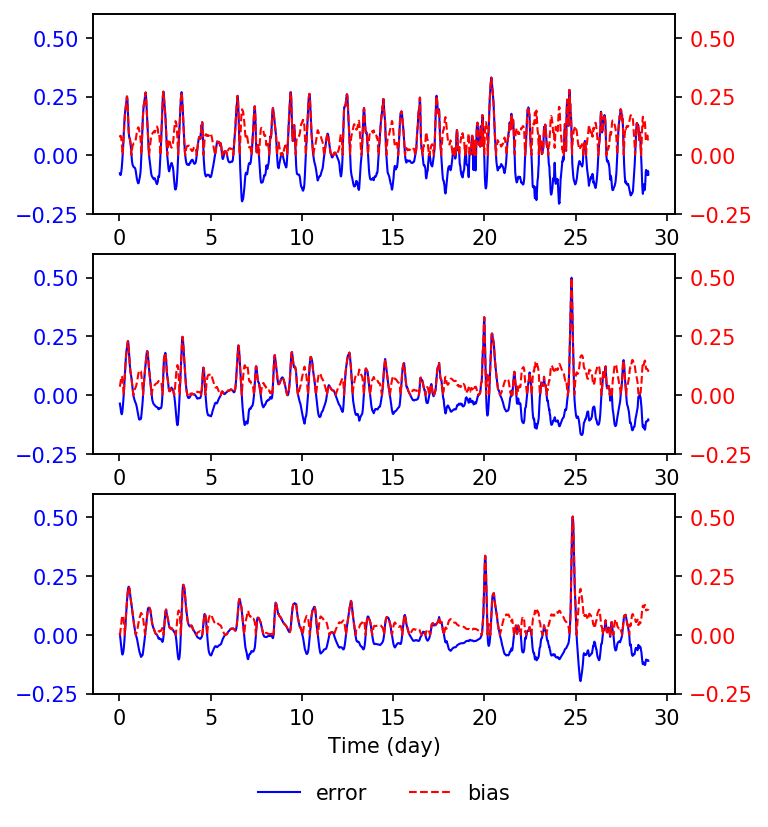

In [194]:
# Plot
fig = plt.figure(num=1, dpi=150, figsize=(5,6), constrained_layout=True)
gs = gridspec.GridSpec(nloc, 1, height_ratios=[1, 1, 1])

# Define axes array
axes = np.empty(nloc, dtype=object)

##############################
# Plot the temporal evolution of the ensemble, the mean, and the observation
# at each observed location
for i in range(nloc):
    posterior_current = posterior_set[i]
    obs_used = obs_value_set_used['TEMPERATURE'][i, :]
    
    # Plot the error
    ax2 = plt.subplot(gs[i])
    diff = np.zeros([ntime, nens])
    for j in range(nens):
        diff[:, j] = posterior_current[1:,j] - obs_used
    diff_mean = np.mean(diff, axis=1)
    diff_mean_abs = np.abs(diff_mean)
    diff_std  = np.std(diff, axis=1)
    line1,=ax2.plot(obs_time_set_used, diff_mean, color='blue', linewidth=1, label='mean')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.set_ylim([-.25,.6])
    
    # Plot the bias
    ax22 = ax2.twinx()  # instantiate a second axes that shares the same x-axis
#     ax22.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
    ax22.tick_params(axis='y', labelcolor='red')
    line2,=ax22.plot(obs_time_set_used, diff_mean_abs, '--', color='red', linewidth=1, label='mean')
    ax22.set_ylim([-.25,.6])
#     line3,=ax2.plot(obs_time_set_used, diff_std, '*-', color='black', linewidth=1, label='mean')

    axes[i] = ax2

# Plot the legends
# plt.legend(frameon=False, ncol=3, loc="upper center", bbox_to_anchor=(0.9, -0.3))
plt.legend((line1, line2), ('error', 'bias'), frameon=False, ncol=3, loc="center", bbox_to_anchor=(0.5, -0.5))

# Plot the labels and titles
# axes[0].set_title("Posterior")
axes[-1].set_xlabel("Time (day)")
# for i in range(nloc):
#     axes[i].set_ylabel("Dimension z: \n %.2f (m)" % (obs_loc_set[2, i]))

In [34]:
# # Plot the temperature

# # Get the parameter
# assim_start_me, assim_start_enks = dar.assim_start_time, "2017-04-01 02:00:00"
# temp_posterior_file = os.path.join(app_dir, "pflotran_input/temp_Kewei_posterior_woflowdir_mda1.txt")
# # flux_posterior_file = os.path.join(app_dir, "pflotran_input/flux_Kewei_posterior_woflowdir.txt")
# # flux_prior_file = os.path.join(app_dir, "pflotran_input/flux_Kewei_prior_woflowdir.txt")

# posterior = np.loadtxt(temp_posterior_file)
# _, nens = posterior.shape

# obs_set               = dar.obs_set
# pflotran_var_set      = dar.pflotran_var_set
# model_time_list       = dar.model_time_list
# model_time_dates_list = dar.model_time_dates_list
# obs_time_set_used     = dar.obs_time_set_used
# obs_value_set_used    = dar.obs_value_set_used
# obs_loc_set           = dar.obs_loc_set

# ntime = len(obs_time_set_used)

# model_time_list2 = np.arange(model_time_list[0], model_time_list[-1], 300./86400)
# spinup_dt_num = int(3600*2/300)
# posterior = posterior[3*spinup_dt_num:,:]
# posterior = posterior[:(len(model_time_list2))*3,:]
# posterior_set = [posterior[::3, :], posterior[1::3, :], posterior[2::3, :]]

# xloc_set, yloc_set, zloc_set = dar.x_loc, dar.y_loc, dar.z_loc

# # Get the locations associated with this observation variable
# _, nloc = obs_loc_set.shape
# # nvar_obs = len(obs_set)

# # Plot
# fig = plt.figure(num=1, dpi=150, figsize=(10,6), constrained_layout=True)
# gs = gridspec.GridSpec(nloc, 2, height_ratios=[1, 1, 1])

# # Define axes array
# axes = np.empty([nloc, 2], dtype=object)

# ##############################
# # Plot the temporal evolution of the ensemble, the mean, and the observation
# # at each observed location
# for i in range(nloc):
#     posterior_current = posterior_set[i]
#     for j in range(nens):
#         posterior_ens = posterior_current[:, j]
#         line1, = ax1.plot(model_time_list2, posterior_ens, color='grey', linewidth=0.5, linestyle=':', label='ensemble')
#     posterior_mean = np.mean(posterior_current, axis=(1))
    
#     # Plot the posterior
#     ax1 = plt.subplot(gs[i, 0])
#     line2, = ax1.plot(model_time_list2, posterior_mean, color='red', linewidth=1, label='mean')
#     obs_used = obs_value_set_used['TEMPERATURE'][i, :]
#     line3, = ax1.plot(obs_time_set_used, obs_used, color='black', linewidth=1, label='obs')
#     ax.set_ylim([4, 10])
    
#     # Plot the statistics
#     ax2 = plt.subplot(gs[i, 1])
#     diff = np.zeros([ntime, nens])
#     for j in range(nens):
#         diff[:, j] = posterior_current[1:,j] - obs_used
#     diff_mean = np.mean(diff, axis=1)
#     diff_mean_abs = np.abs(diff_mean)
#     diff_std  = np.std(diff, axis=1)
#     ax2.plot(obs_time_set_used, diff_mean, color='blue', linewidth=1, label='mean')
#     ax2.plot(obs_time_set_used, diff_mean_abs, '--', color='blue', linewidth=1, label='mean')
#     ax2.plot(obs_time_set_used, diff_std, '*-', color='black', linewidth=1, label='mean')

#     axes[i, 0] = ax1
#     axes[i, 1] = ax2

# # Plot the legends
# # plt.legend(frameon=False, ncol=3, loc="upper center", bbox_to_anchor=(0.9, -0.3))
# plt.legend((line1, line2, line3), ('ensemble', 'mean', 'true'), frameon=False, ncol=3, loc="center", bbox_to_anchor=(0.5, -0.5))

# # Plot the labels and titles
# axes[0].set_title("Posterior")
# axes[-1].set_xlabel("Time (day)")
# for i in range(nloc):
#     axes[i].set_ylabel("Dimension z: \n %.2f (m)" % (obs_loc_set[2, i]))

ValueError: operands could not be broadcast together with shapes (8340,100) (8340,) 

In [ ]:
# # Get the Kewei's results
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib import gridspec
# from datetime import datetime

# assim_start_me, assim_start_enks = dar.assim_start_time, "2017-04-01 02:00:00"
# flux_posterior_file = os.path.join(app_dir, "pflotran_input/flux_Kewei_posterior_woflowdir_mda1_reso5min2.txt")
# flux_prior_file = os.path.join(app_dir, "pflotran_input/flux_Kewei_prior_woflowdir_mda1_reso5min2.txt")
# # flux_posterior_file = os.path.join(app_dir, "pflotran_input/flux_Kewei_posterior_woflowdir.txt")
# # flux_prior_file = os.path.join(app_dir, "pflotran_input/flux_Kewei_prior_woflowdir.txt")
# true_set = pd.read_csv(flux_file)
# prior, posterior = np.loadtxt(flux_prior_file), np.loadtxt(flux_posterior_file)
# _, nens = prior.shape
# assim_window = 1. / 24. / 12.  # Kewei's assimilation window (5min)
# fraction = int(assim_window / dar.assim_window)

In [ ]:
# # Get the time index
# model_start_time, model_end_time = dar.model_start_time, dar.model_end_time
# ref_time           = datetime.strptime(assim_start_me, "%Y-%m-%d %H:%M:%S")
# true_set_raw_time  = true_set.iloc[:, 0].values
# true_set_dates     = np.array([datetime.strptime(t, '%m/%d/%Y %H:%M') for t in true_set_raw_time])
# dates_ref          = [t-ref_time for t in true_set_dates]
# true_set_time      = np.array([t.days+float(t.seconds)/86400. for t in dates_ref])
# true               = true_set.iloc[:, 1].values
# true_set_used_ind  = (true_set_time >= model_start_time) & (true_set_time <= model_end_time)
# true_set_time_used = true_set_time[true_set_used_ind]
# true_set_used      = true[true_set_used_ind]

# # ref_time_enks      = datetime.strptime(assim_start_enks, "%Y-%m-%d %H:%M:%S")
# # enks_set_time = true_set_time[true_set_dates > ref_time_enks]
# # enks_ind  = (enks_set_time >= model_start_time) & (enks_set_time <= model_end_time)
# model_time_list = [dar.model_time_list[i] for i in range(len(dar.model_time_list))  if i % fraction == 0]
# ntime = len(model_time_list)
# analyzed_prior_ens = prior[1:1+ntime,:].T
# analyzed_posterior_ens = posterior[1:1+ntime, :].T

In [ ]:
# # Plot
# ylim=[-4, 4]
# fig = plt.figure(num=1, dpi=150,figsize=(10, 3), constrained_layout=True)
# gs  = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
# # Plot the prior
# ax1 = plt.subplot(gs[0, 0])
# for j in range(nens):
#     prior_ens = analyzed_prior_ens[j, :]
#     line1, = ax1.plot(model_time_list, prior_ens, color='grey',
#                       linewidth=0.5, linestyle=':', label='ensemble')
# prior_mean = np.mean(analyzed_prior_ens, axis=(0))
# line2, = ax1.plot(model_time_list, prior_mean, color='red',
#                   linewidth=1, label='mean')
# line3, = ax1.plot(true_set_time_used, true_set_used, color='black',
#                   linewidth=1, label='obs')

# # Plot the posterior
# ax2 = plt.subplot(gs[0, 1])
# for j in range(nens):
#     posterior_ens = analyzed_posterior_ens[j, :]
#     line1, = ax2.plot(model_time_list, posterior_ens, color='grey',
#                       linewidth=0.5, linestyle=':', label='ensemble')
# posterior_mean = np.mean(analyzed_posterior_ens, axis=(0))
# line2, = ax2.plot(model_time_list, posterior_mean, color='red',
#                   linewidth=1, label='mean')
# line3, = ax2.plot(true_set_time_used, true_set_used, color='black',
#                   linewidth=1, label='obs')

# # Plot the legends
# plt.legend((line1, line2, line3), ('ensemble', 'mean', 'obs'),
#            frameon=False, ncol=3, loc="center", bbox_to_anchor=(0.0, -0.5))

# # Plot the labels and titles
# ax1.set_title("Prior ({} from Kewei) \n assimilation window: 5min".format('FLOW_FLUX'))
# ax2.set_title("Posterior ({} from Kewei) \n assimilation window: 5min".format('FLOW_FLUX'))
# ax1.set_xlabel("Time (day)")
# ax2.set_xlabel("Time (day)")
# ax1.set_ylim(ylim)
# ax2.set_ylim(ylim);